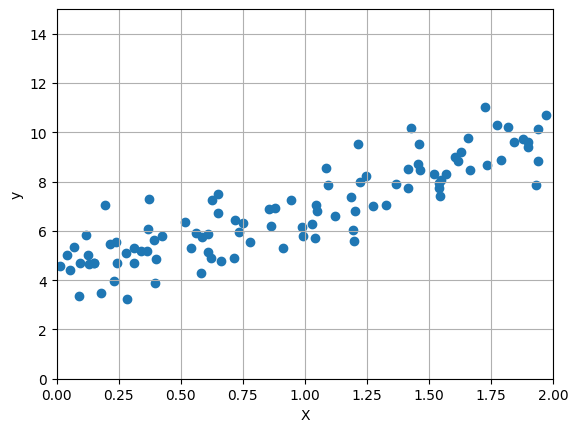

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

m = 100
X = 2 * np.random.rand(m, 1)  # col vector
y = 4 + 3 * X + np.random.randn(m, 1)


plt.scatter(X, y)

plt.xlabel('X')
plt.ylabel('y')

plt.ylim(0, 15)
plt.xlim(0.00, 2.00)

plt.grid()

plt.show()

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
# try out the Normal equation to solve Linear Regression
# theta = (X^T x X)^-1 x X^T x y
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y


print(theta_best)  # very close to the theta0 = 4 and theta1 = 3

X_new = np.array([ [0], [2] ])
X_new_b = add_dummy_feature(X_new)
y_pred = X_new_b @ theta_best
print(y_pred)

[[4.21509616]
 [2.77011339]]
[[4.21509616]
 [9.75532293]]


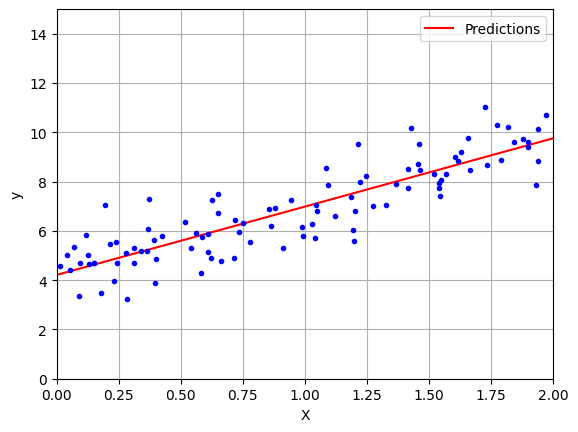

In [8]:
plt.plot(X_new, y_pred, 'r-', label='Predictions')
plt.plot(X, y, 'b.')

plt.legend()
plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 15)
plt.xlim(0.00, 2.00)

plt.show()

In [9]:
# using sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


In [11]:
# LinearRegression class is based on scipy.lingal.lstsq ("least squares")
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

# lstsq computes X+ x y
# X+ is the Moore-Penrose inverse/pseudoinverse of X
print(np.linalg.pinv(X_b) @ y)

# the pseudoinverse is computed using Singular Value Decomposition (np.linalg.svd)
# which decomposes X into U, E, V
# pseudoinverse is then X+ = V x E+ x U^T
# for E+, zero out all values in E that are smaller than a tiny threshold, then replace all non-zero with their inverse and then transpose the matrix

# this works faster than computing the Normal equation directly + handles edge cases (e.g. when "X^T x X" is not invertible)


[[4.21509616]
 [2.77011339]]
[[4.21509616]
 [2.77011339]]


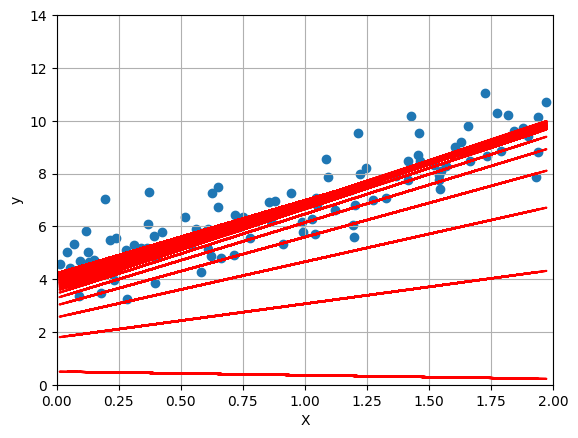

[[4.21509616]
 [2.77011339]]


In [17]:
# Normal equation and SVD are linear wrt number of instances, good for large training sets that can fit in memory
# if the number of features is very large, then don't use Normal equation

# using GD
eta = 0.1  # learning rate
n_epochs = 1_000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure()
plt.scatter(X, y)
for epoch in range(n_epochs):
    y_hat = X_b @ theta
    diff = y_hat - y
    grads = 2 / m * X_b.T @ diff
    theta -= eta * grads

    plt.plot(X, y_hat, 'r')

plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 14)
plt.xlim(0.00, 2.0)
plt.show()

print(theta)

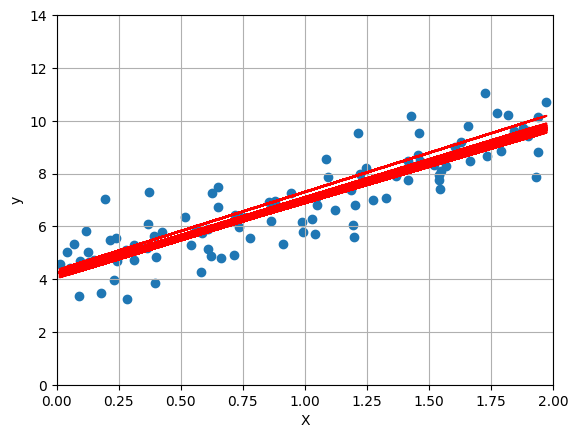

[[4.21076011]
 [2.74856079]]


In [21]:
# using SGD
eta = 0.1
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparams
m = len(X_b)

def learning_schedule(t): return t0 / (t + t1)
np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure()
plt.scatter(X, y)
for epoch in range(n_epochs):
    for iter_ in range(m):
        # randomly pick 1 instance
        rand_idx = np.random.randint(m)
        xi = X_b[rand_idx : rand_idx + 1]
        yi = y[rand_idx : rand_idx + 1]

        y_hat_i = xi @ theta
        diff = y_hat_i - yi
        
        grads = 2 * xi.T @ diff  # don't divide by m for SGD
        eta = learning_schedule(epoch * m + iter_)
        
        theta -= eta*grads

    plt.plot(X, X_b @ theta, 'r')

plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(0, 14)
plt.xlim(0.00, 2.0)
plt.show()

print(theta)

In [22]:
# using sklearn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1_000,
                       # stop if loss falls below "tol" during "n_iter_no_change"
                       tol=1e-5,
                       # no regularization (penalty)
                       penalty=None,
                       eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # ravel() cuz fit expects 1D target

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.21278812] [2.77270267]


In [ ]:
# resume from pg. 248